In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from itertools import product
import scipy.linalg as la

# TB Model for AuSiC

### 8 Wannier orbitals:
1. Au sp2 hybrid  
2. Au sp2 hybrid  
3. Au pz  
4. Au sp2 hybrid  
5. Au dz²  
6. Au dx²-y²  
7. Au dxy  
8. Si pz

In [18]:
# ============================================================
# Section 1: Wannier TB Model (without SOC)
# ============================================================

# Load preprocessed Wannier data
data = np.load('wannier_processed.npz')
nbands = int(data['nbands'])       # 8 Wannier orbitals
NRPTS = int(data['NRPTS'])         # 633 R-vectors
NHam = int(data['NHam'])           # 64 = 8x8 matrix elements
degVals = data['degVals']          # degeneracy weights (633,)

# R-vectors (integer lattice coords) — one per R-point
R_vectors = data['LatticeVectors'][:, 0, :].astype(int)  # (633, 3)

# Hopping matrices reshaped to (NRPTS, nbands, nbands)
Hopping = data['Hopping'].reshape(NRPTS, nbands, nbands)

# Apply degeneracy: H_mn(R) = hopping / deg
HamMatrix = np.zeros_like(Hopping)
for iR in range(NRPTS):
    HamMatrix[iR] = Hopping[iR] / degVals[iR]

print(f"nbands={nbands}, NRPTS={NRPTS}")
print(f"R-vector range: [{R_vectors.min()}, {R_vectors.max()}]")

# Find R=0 index
R0_idx = np.where(np.all(R_vectors == 0, axis=1))[0][0]
print(f"R=0 at index {R0_idx}")
print(f"On-site energies: {np.diag(HamMatrix[R0_idx]).real}")

nbands=8, NRPTS=633
R-vector range: [-16, 16]
R=0 at index 316
On-site energies: [8.023925 7.727246 6.220938 7.724679 0.685107 1.065552 0.362589 4.941291]


In [19]:
# Lattice vectors (from wannier90 .xsf files)
a1 = np.array([3.0960000, 0.0000000, 0.0000000])
a2 = np.array([-1.5480000, 2.6812150, 0.0000000])
a3 = np.array([0.0000000, 0.0000000, 20.0000000])

# Reciprocal lattice vectors (with 2pi factor)
V = np.dot(a1, np.cross(a2, a3))
b1 = 2 * np.pi * np.cross(a2, a3) / V
b2 = 2 * np.pi * np.cross(a3, a1) / V
b3 = 2 * np.pi * np.cross(a1, a2) / V
print(f"Real lattice: a = {np.linalg.norm(a1):.4f} Å")
print(f"b1 = {b1}")
print(f"b2 = {b2}")

# Real-space lattice matrix (rows = lattice vectors)
A = np.array([a1, a2, a3])
# Reciprocal lattice matrix (rows = recip vectors)
B = np.array([b1, b2, b3])

Real lattice: a = 3.0960 Å
b1 = [ 2.02945262  1.17170486 -0.        ]
b2 = [0.         2.34340973 0.        ]


In [20]:
def Hamfun(k):
    """Construct H(k) via Fourier transform of Wannier hopping.
    
    k = (k1, k2, k3) in fractional coordinates (no 2*pi factor).
    
    H(k) = sum_R H(R)/deg(R) * exp(2*pi*i k.R)
    """
    k = np.asarray(k, dtype=float)
    phases = np.exp(2j * np.pi * R_vectors @ k)  # (NRPTS,)
    Hk = np.einsum('r,rmn->mn', phases, HamMatrix)
    return Hk

def solve_ham(k, EFermi=0.0):
    """Diagonalize H(k), return sorted eigenvalues and eigenvectors."""
    Hk = Hamfun(k)
    eigvals, eigvecs = la.eigh(Hk)
    return eigvals - EFermi, eigvecs

# High-symmetry points in fractional coordinates
KG = np.array([0, 0, 0], dtype=float)           # Gamma
KK = np.array([1/3, 1/3, 0])                     # K
KM = np.array([1/2, 0, 0])                       # M
KKp = np.array([1/3, -1/3, 0])                   # K'

# Fermi energy (from DFT)
EFermi = 2.71  # eV, matches Mathematica

# Quick test at Gamma
eigvals_G, _ = solve_ham(KG)
print(f"Eigenvalues at Gamma (raw): {eigvals_G + EFermi}")
print(f"Eigenvalues at Gamma (E-EF): {eigvals_G}")

Eigenvalues at Gamma (raw): [-0.3527552   0.80720415  1.78468602  1.78536235  5.421387   14.87329774
 19.07099568 19.08433326]
Eigenvalues at Gamma (E-EF): [-3.0627552  -1.90279585 -0.92531398 -0.92463765  2.711387   12.16329774
 16.36099568 16.37433326]


In [21]:
def make_kpath(points, labels, npts_per_seg=100):
    """Generate k-path through high-symmetry points.
    
    points are in fractional coordinates.
    Returns: kpoints (N,3), x_axis (N,), xticks, xticklabels
    """
    kpoints = []
    x = []
    xtick_pos = [0.0]
    
    x_current = 0.0
    for i in range(len(points) - 1):
        k_start, k_end = np.array(points[i]), np.array(points[i+1])
        # k is fractional; convert dk to Cartesian for proper distance
        dk_frac = k_end - k_start
        dk_cart = dk_frac @ B  # Cartesian recip vector
        seg_length = np.linalg.norm(dk_cart)
        
        for j in range(npts_per_seg):
            t = j / npts_per_seg
            kpoints.append(k_start + t * (k_end - k_start))
            x.append(x_current + t * seg_length)
        
        x_current += seg_length
        xtick_pos.append(x_current)
    
    # Add final point
    kpoints.append(np.array(points[-1]))
    x.append(x_current)
    
    return np.array(kpoints), np.array(x), xtick_pos, labels

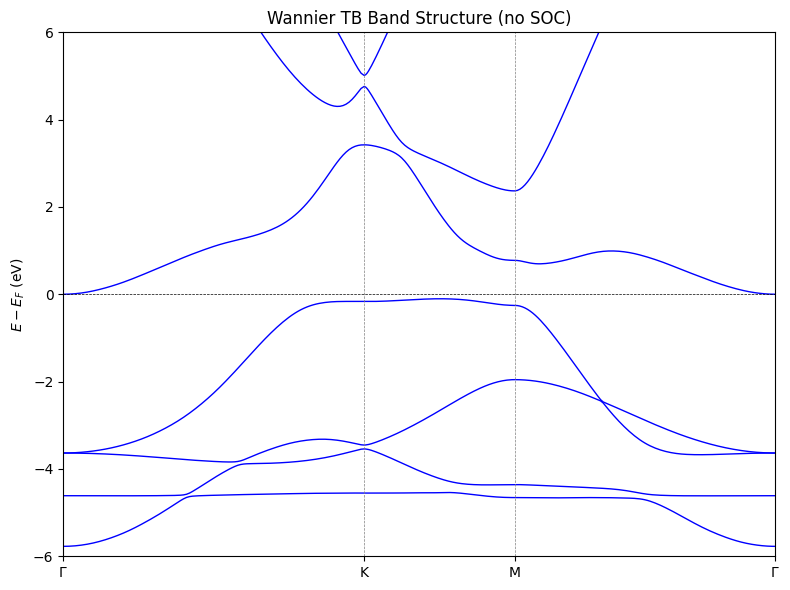

In [22]:
# Compute Wannier band structure along Gamma-K-M-Gamma
kpts, x_axis, xticks, xlabels = make_kpath(
    [KG, KK, KM, KG],
    [r'$\Gamma$', 'K', 'M', r'$\Gamma$'],
    npts_per_seg=100
)

bands = np.array([solve_ham(k, EFermi)[0] for k in kpts])  # (Nk, 8)

fig, ax = plt.subplots(figsize=(8, 6))
for ib in range(nbands):
    ax.plot(x_axis, bands[:, ib], 'b-', linewidth=1.0)

for xt in xticks:
    ax.axvline(xt, color='gray', linewidth=0.5, linestyle='--')
ax.axhline(0, color='k', linewidth=0.5, linestyle='--', label=r'$E_F$')

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_ylabel(r'$E - E_F$ (eV)')
ax.set_title('Wannier TB Band Structure (no SOC)')
ax.set_xlim(x_axis[0], x_axis[-1])
ax.set_ylim(-6, 6)
plt.tight_layout()
plt.show()

## Section 2: Comparison with DFT bands (no SOC)

In [23]:
# Load DFT band data (no SOC)
dft_noSOC = np.load('bands_data-noSOC.npz')
dft_kpoints = dft_noSOC['kpoints']     # (60, 3) Cartesian coords
dft_eigenval = dft_noSOC['eigenval']   # (60, 120, 2, 1) — eigenvalues at index [:,:,0,0]
dft_efermi = float(dft_noSOC['efermi'])
dft_procar = dft_noSOC['procar']       # (60, 120, 8, 17, 1)

# DFT kpath: Gamma -> M -> K -> Gamma, 20 pts per segment
kpoints_tags = {"nPts_each_seg": 20, "seg_labels": [["Γ", "M"], ["M", "K"], ["K", "Γ"]]}

print(f"DFT Fermi energy: {dft_efermi:.4f} eV")
print(f"DFT kpoints shape: {dft_kpoints.shape}")
print(f"DFT eigenval shape: {dft_eigenval.shape}")

# DFT kpoints are in Cartesian units (1/(2*pi) of actual reciprocal vectors)
# i.e., k_cart_DFT = k_frac @ B / (2*pi)
# To get 2*pi*fractional for Wannier: k_wannier = B^(-1) @ k_cart * 2*pi
# But since k_cart_DFT = k_frac @ B/(2*pi), we have k_frac = k_cart_DFT @ (B/(2*pi))^(-1)
# Then k_wannier = 2*pi * k_frac = 2*pi * k_cart_DFT @ (B/(2*pi))^(-1)

# Build DFT kpath x-axis (using Cartesian distances)
dft_x = np.zeros(len(dft_kpoints))
for i in range(1, len(dft_x)):
    dft_x[i] = dft_x[i-1] + np.linalg.norm(dft_kpoints[i] - dft_kpoints[i-1])
# Remove jumps between segments
n_seg = 3
npts = 20
for iseg in range(1, n_seg):
    jump = dft_x[iseg*npts] - dft_x[iseg*npts - 1]
    dft_x[iseg*npts:] -= jump

dft_xticks = [dft_x[0], dft_x[19], dft_x[39], dft_x[59]]
dft_xlabels = [r'$\Gamma$', 'M', 'K', r'$\Gamma$']
print(f"DFT xtick positions: {dft_xticks}")

DFT Fermi energy: 2.6588 eV
DFT kpoints shape: (60, 3)
DFT eigenval shape: (60, 120, 2, 1)
DFT xtick positions: [0.0, 0.18648264053843416, 0.2941484336805866, 0.5094800249648785]


In [24]:
# Convert DFT Cartesian kpoints to fractional coordinates
# DFT kpoints are in Cartesian with 2*pi factored out:
#   k_DFT = k_frac @ B/(2*pi) = k_frac @ B_no2pi
# => k_frac = k_DFT @ inv(B_no2pi)
# Note: inv(B_no2pi) = A^T (standard crystallographic relation)

B_no2pi = B / (2 * np.pi)
k_frac_all = dft_kpoints @ np.linalg.inv(B_no2pi)  # (60, 3)

# Verify: M (idx 19) -> (1/2, 0, 0), K (idx 39) -> (1/3, 1/3, 0)
print("M point fractional:", np.round(k_frac_all[19], 4))
print("K point fractional:", np.round(k_frac_all[39], 4))

# k is now directly fractional — same convention as KK, KM
dft_k_wannier = k_frac_all  # (60, 3)

print(f"\nK point in Wannier convention: {np.round(dft_k_wannier[39], 4)}")
print(f"Expected KK = {np.round(KK, 4)}")

M point fractional: [ 0.5 -0.   0. ]
K point fractional: [0.3333 0.3333 0.    ]

K point in Wannier convention: [0.3333 0.3333 0.    ]
Expected KK = [0.3333 0.3333 0.    ]


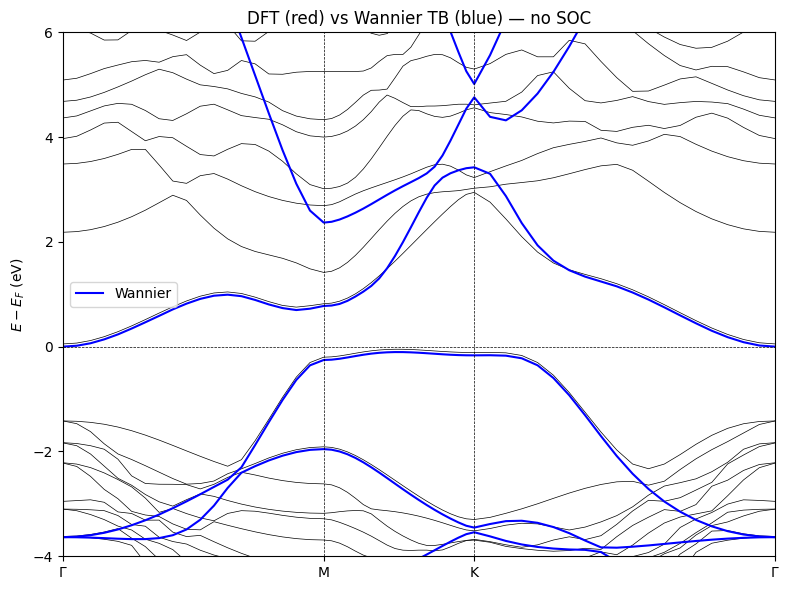

In [25]:
# Compute Wannier bands at DFT kpoints for comparison
wannier_bands_at_dft = np.array([solve_ham(k, EFermi)[0] for k in dft_k_wannier])  # (60, 8)
dft_bands = dft_eigenval[:, :, 0, 0] - dft_efermi  # (60, 120), shifted to E-EF

# Plot: DFT bands (gray) + Wannier bands (blue)
fig, ax = plt.subplots(figsize=(8, 6))

# DFT bands (all 120 bands, red)
for ib in range(dft_bands.shape[1]):
    ax.plot(dft_x, dft_bands[:, ib], color='black', linewidth=0.5)

# Wannier bands (8 bands, blue)
for ib in range(nbands):
    ax.plot(dft_x, wannier_bands_at_dft[:, ib], 'b-', linewidth=1.5,
            label='Wannier' if ib == 0 else None)

for xt in dft_xticks:
    ax.axvline(xt, color='black', linewidth=0.5, linestyle='--')
ax.axhline(0, color='k', linewidth=0.5, linestyle='--')

ax.set_xticks(dft_xticks)
ax.set_xticklabels(dft_xlabels)
ax.set_ylabel(r'$E - E_F$ (eV)')
ax.set_title('DFT (red) vs Wannier TB (blue) — no SOC')
ax.set_xlim(dft_x[0], dft_x[-1])
ax.set_ylim(-4, 6)
ax.legend()
plt.tight_layout()
plt.show()

## Section 3: Effective k·p Model at K point (no SOC)

Expand H(k) around the K point to 2nd order, where $H(\mathbf{k}) = \sum_R H(R)\, e^{2\pi i \mathbf{k}\cdot\mathbf{R}}$:

$$H(\mathbf{K} + \mathbf{q}) \approx H^{(0)} + \sum_i H^{(1)}_i q_i + \sum_{ij} H^{(2)}_{ij} q_i q_j$$

where:
- $H^{(0)} = \sum_R H(R)\, e^{2\pi i\mathbf{K}\cdot\mathbf{R}}$
- $H^{(1)}_i = 2\pi i \sum_R H(R)\, R_i\, e^{2\pi i\mathbf{K}\cdot\mathbf{R}}$  
- $H^{(2)}_{ij} = -2\pi^2 \sum_R H(R)\, R_i R_j\, e^{2\pi i\mathbf{K}\cdot\mathbf{R}}$

In [26]:
# k.p expansion at K point
# With H(k) = sum_R H(R) exp(2*pi*i k.R), the Taylor expansion gives:
#   H0       = sum_R H(R) exp(2*pi*i K.R)
#   H1_i     = 2*pi*i * sum_R H(R) R_i exp(2*pi*i K.R)
#   H2_{ij}  = -2*pi^2 * sum_R H(R) R_i R_j exp(2*pi*i K.R)

K0 = KK  # expansion point

# Compute phases at K0 for all R
phases_K0 = np.exp(2j * np.pi * R_vectors @ K0)  # (NRPTS,)

# Zero-order: H(K0)
H0_eff = np.einsum('r,rmn->mn', phases_K0, HamMatrix)

# First-order: dH/dk_i = 2*pi*i * sum_R H(R) R_i exp(2*pi*i K.R)
H1_eff = np.zeros((2, nbands, nbands), dtype=complex)
for i in range(2):
    H1_eff[i] = 2j * np.pi * np.einsum('r,r,rmn->mn', R_vectors[:, i].astype(float), phases_K0, HamMatrix)

# Second-order: (1/2) d2H/dk_i dk_j = -2*pi^2 * sum_R H(R) R_i R_j exp(2*pi*i K.R)
H2_eff = np.zeros((2, 2, nbands, nbands), dtype=complex)
for i in range(2):
    for j in range(2):
        H2_eff[i, j] = -2 * np.pi**2 * np.einsum(
            'r,r,r,rmn->mn',
            R_vectors[:, i].astype(float),
            R_vectors[:, j].astype(float),
            phases_K0,
            HamMatrix
        )

print("H0 eigenvalues:", np.sort(la.eigvalsh(H0_eff)))
print("\nMax |H1[0]|:", np.abs(H1_eff[0]).max())
print("Max |H1[1]|:", np.abs(H1_eff[1]).max())
print("Max |H2[0,0]|:", np.abs(H2_eff[0,0]).max())

H0 eigenvalues: [-1.84261136 -0.83132811 -0.74235609  2.54486933  6.13378853  7.46991363
  7.72374608 15.13225867]

Max |H1[0]|: 16.906791128082858
Max |H1[1]|: 15.901222063414107
Max |H2[0,0]|: 66.63630353261658


In [33]:
def Hameff(q):
    """Effective Hamiltonian at K0 + q (2nd order k.p expansion).
    
    q = (q1, q2) is the deviation from K0 in the same units.
    """
    H = H0_eff.copy()
    for i in range(2):
        H += H1_eff[i] * q[i]
    for i in range(2):
        for j in range(2):
            H += H2_eff[i, j] * q[i] * q[j]
    return H

def solve_eff(q, EFermi=0.0):
    """Diagonalize effective Hamiltonian."""
    eigvals = la.eigvalsh(Hameff(q))
    return eigvals - EFermi

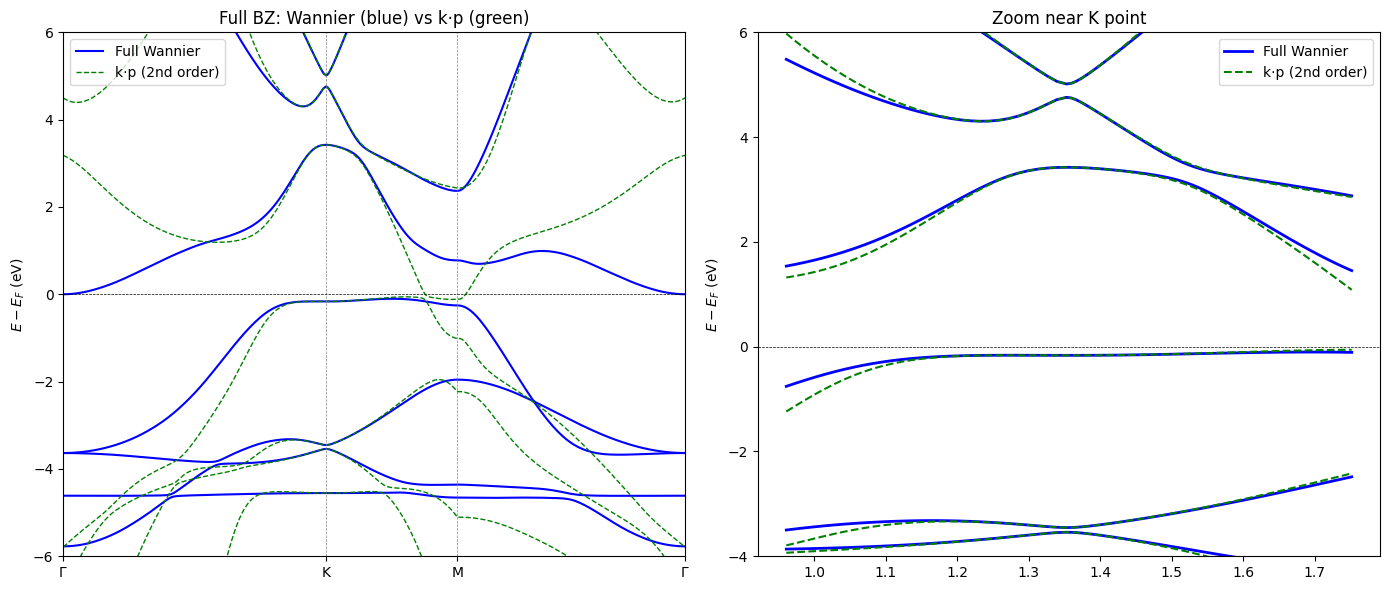

In [34]:
# Compare effective model with full Wannier near K point
# Use path: G <- K -> M (zoom into K neighborhood)
kpts2, x2, xticks2, xlabels2 = make_kpath(
    [KG, KK, KM, KG],
    [r'$\Gamma$', 'K', 'M', r'$\Gamma$'],
    npts_per_seg=100
)

# Full Wannier bands
bands_full = np.array([solve_ham(k, EFermi)[0] for k in kpts2])

# Effective model bands (q = k - K0)
bands_eff = np.array([solve_eff(k[:2] - K0[:2], EFermi) for k in kpts2])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: full BZ comparison
ax = axes[0]
for ib in range(nbands):
    ax.plot(x2, bands_full[:, ib], 'b-', linewidth=1.5,
            label='Full Wannier' if ib == 0 else None)
    ax.plot(x2, bands_eff[:, ib], 'g--', linewidth=1.0,
            label='k·p (2nd order)' if ib == 0 else None)
for xt in xticks2:
    ax.axvline(xt, color='gray', linewidth=0.5, linestyle='--')
ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax.set_xticks(xticks2)
ax.set_xticklabels(xlabels2)
ax.set_ylabel(r'$E - E_F$ (eV)')
ax.set_title('Full BZ: Wannier (blue) vs k·p (green)')
ax.set_xlim(x2[0], x2[-1])
ax.set_ylim(-6, 6)
ax.legend()

# Right panel: zoom near K
ax = axes[1]
K_x = xticks2[1]
dx = (xticks2[2] - xticks2[0]) * 0.2  # zoom window
mask = (x2 > K_x - dx) & (x2 < K_x + dx)
for ib in range(nbands):
    ax.plot(x2[mask], bands_full[mask, ib], 'b-', linewidth=2.0,
            label='Full Wannier' if ib == 0 else None)
    ax.plot(x2[mask], bands_eff[mask, ib], 'g--', linewidth=1.5,
            label='k·p (2nd order)' if ib == 0 else None)
ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
ax.set_ylabel(r'$E - E_F$ (eV)')
ax.set_title('Zoom near K point')
ax.set_ylim(-4, 6)
ax.legend()

plt.tight_layout()
plt.show()

## Section 4: Atomic Spin-Orbit Coupling (SOC)

The atomic SOC Hamiltonian is $H_{\rm SOC} = \lambda\, \mathbf{L}\cdot\mathbf{S} = \lambda\left(L_z S_z + \frac{1}{2}L_+ S_- + \frac{1}{2}L_- S_+\right)$.

Since the $s$ orbital has $l=0$, SOC acts only on the $p$- and $d$-orbital components. Two independent SOC parameters are needed: $\lambda_1$ for the Au $p$-orbital sector (sp2 hybrids + $p_z$) and $\lambda_2$ for the Au $d$-orbital sector.

---

### $\lambda_2$ sector: d orbitals $\{d_{z^2},\, d_{x^2-y^2},\, d_{xy}\}$ (orbitals 5-7)

Express in spherical harmonics:

$$d_{z^2} = Y_2^0,\qquad d_{x^2-y^2} = \tfrac{1}{\sqrt{2}}(Y_2^2 + Y_2^{-2}),\qquad d_{xy} = \tfrac{i}{\sqrt{2}}(-Y_2^2 + Y_2^{-2})$$

Since $L_z Y_l^m = m\hbar\, Y_l^m$, the only non-vanishing matrix element of $L_z$ in this subspace is:

$$\langle d_{x^2-y^2}|L_z|d_{xy}\rangle = -2i\hbar$$

The $L_\pm$ operators change $m$ by $\pm 1$, but the states $|2,\pm 2\rangle$ can only reach $|2,\pm 1\rangle$ (i.e. $d_{xz}, d_{yz}$), which are **not in our basis**. Similarly $L_\pm|2,0\rangle \propto |2,\pm 1\rangle$. Therefore $L_\pm S_\mp$ contributes **nothing** in this subspace, and only $L_z S_z$ survives:

$$H_{\rm SOC}^{(d)} = \lambda_2 L_z S_z \implies \text{only entries } (d_{x^2-y^2}, d_{xy}): \begin{cases} \uparrow\uparrow: -2i\lambda_2 \\ \downarrow\downarrow: +2i\lambda_2 \end{cases} \text{ (+ h.c.)}$$

The Si $p_z$ orbital (orbital 8) has no on-site Au SOC, so it adds a zero row/column.

---

### $\lambda_1$ sector: sp2 hybrids + $p_z$ (orbitals 1-4)

The sp2 hybridization is:

| Orbital | Decomposition |
|---------|--------------|
| sp2(1) | $\frac{1}{\sqrt{3}}s + \frac{1}{\sqrt{2}}p_x + \frac{1}{\sqrt{6}}p_y$ |
| sp2(2) | $\frac{1}{\sqrt{3}}s - \frac{2}{\sqrt{6}}p_y$ |
| $p_z$   | $p_z$ |
| sp2(4) | $\frac{1}{\sqrt{3}}s - \frac{1}{\sqrt{2}}p_x + \frac{1}{\sqrt{6}}p_y$ |

Since $\langle s|\mathbf{L}|{\rm anything}\rangle = 0$, only the $p$-orbital components contribute.  The transformation from $\{p_x, p_y, p_z\}$ to $\{{\rm sp2}_1, {\rm sp2}_2, p_z, {\rm sp2}_3\}$ (extracting $p$-components only) is:

$$U = \begin{pmatrix} 1/\sqrt{2} & 1/\sqrt{6} & 0 \\ 0 & -2/\sqrt{6} & 0 \\ 0 & 0 & 1 \\ -1/\sqrt{2} & 1/\sqrt{6} & 0 \end{pmatrix}_{4\times 3}$$

The SOC matrix of $\mathbf{L}\cdot\mathbf{S}$ in the $\{p_x, p_y, p_z\}\otimes\{\uparrow,\downarrow\}$ basis is known analytically (6$\times$6). We then transform:

$$H_{\rm SOC}^{(\rm sp2/pz)} = (U\otimes I_{\rm spin})\; H_{\rm SOC}^{(p)}\; (U\otimes I_{\rm spin})^\dagger \quad (8\times 8)$$

This gives the full $L_z S_z + \frac{1}{2}L_+ S_- + \frac{1}{2}L_- S_+$ coupling among all four orbitals, with the characteristic constants:

$$a = \frac{i\lambda_1}{\sqrt{3}},\quad b = i\sqrt{\frac{2}{3}}\,\lambda_1,\quad c = \frac{\lambda_1}{\sqrt{2}} + \frac{i\lambda_1}{\sqrt{6}},\quad d = \bar{c} = \frac{\lambda_1}{\sqrt{2}} - \frac{i\lambda_1}{\sqrt{6}}$$

Unlike the $d$-orbital case, both $L_zS_z$ and $L_\pm S_\mp$ contribute here because $L_\pm$ connects $p_z$ ($m=0$) to $p_x \pm ip_y$ ($m=\pm 1$), and all these components are present in our basis through the sp2 hybrids.

---

### Assembly into 16by16

Each 8$\times$8 SOC block (sp2/pz or d/Si) is split into four 4$\times$4 spin sub-blocks ($\uparrow\uparrow$, $\uparrow\downarrow$, $\downarrow\uparrow$, $\downarrow\downarrow$), then interleaved as:

$$H_{\rm SOC}^{16\times 16} = \begin{pmatrix} B_{\uparrow\uparrow} & B_{\uparrow\downarrow} \\ B_{\downarrow\uparrow} & B_{\downarrow\downarrow}\end{pmatrix}, \qquad B_{\sigma\sigma'} = \begin{pmatrix} {\rm SOC3}_{\sigma\sigma'} & 0 \\ 0 & {\rm SOC2}_{\sigma\sigma'}\end{pmatrix}_{8\times 8}$$

Fitted parameters: $\lambda_1 = 0.5$ eV, $\lambda_2 = 0.2$ eV.

In [29]:
def build_HamSOC(lambda1, lambda2):
    """Build the 16x16 SOC matrix H_SOC(lambda1, lambda2).
    
    Basis: {orb1↑,...,orb8↑, orb1↓,...,orb8↓}
    where orb = {sp2_1, sp2_2, pz, sp2_3, dz2, dx2-y2, dxy, Si_pz}
    
    lambda1: SOC parameter for sp2/pz orbitals
    lambda2: SOC parameter for d orbitals (LzSz only)
    """
    # --- HamSOCtmp1: 6x6 d-orbital LzSz SOC (lambda2) ---
    # Basis: {dz2↑, dx2-y2↑, dxy↑, dz2↓, dx2-y2↓, dxy↓}
    # Only off-diagonal: (dx2-y2, dxy) coupled by ±2i*lambda2
    SOC1 = np.zeros((6, 6), dtype=complex)
    SOC1[1, 2] = -2j * lambda2   # dx2-y2↑, dxy↑
    SOC1[2, 1] =  2j * lambda2   # dxy↑, dx2-y2↑
    SOC1[4, 5] =  2j * lambda2   # dx2-y2↓, dxy↓
    SOC1[5, 4] = -2j * lambda2   # dxy↓, dx2-y2↓
    
    # --- HamSOCtmp2: 8x8, pad SOC1 with Si_pz (zeros) ---
    # ↑↑ block: SOC1[0:3, 0:3] padded to 4x4
    SOC2_uu = np.zeros((4, 4), dtype=complex)
    SOC2_uu[:3, :3] = SOC1[:3, :3]
    # ↓↓ block: SOC1[3:6, 3:6] padded to 4x4
    SOC2_dd = np.zeros((4, 4), dtype=complex)
    SOC2_dd[:3, :3] = SOC1[3:6, 3:6]
    # SOC1 has no ↑↓ or ↓↑ blocks (LzSz only)
    SOC2 = np.block([
        [SOC2_uu, np.zeros((4, 4), dtype=complex)],
        [np.zeros((4, 4), dtype=complex), SOC2_dd]
    ])
    
    # --- HamSOCtmp3: 8x8 sp2/pz SOC (lambda1) ---
    # Basis: {sp2_1↑, sp2_2↑, pz↑, sp2_3↑, sp2_1↓, sp2_2↓, pz↓, sp2_3↓}
    a = 1j * lambda1 / np.sqrt(3)
    b = 1j * np.sqrt(2.0/3) * lambda1
    c = lambda1 / np.sqrt(2) + 1j * lambda1 / np.sqrt(6)
    d = lambda1 / np.sqrt(2) - 1j * lambda1 / np.sqrt(6)  # = conj(c)
    
    SOC3 = np.zeros((8, 8), dtype=complex)
    # Row 0: sp2_1↑
    SOC3[0, 1] =  a;  SOC3[0, 3] = -a;  SOC3[0, 6] = d
    # Row 1: sp2_2↑
    SOC3[1, 0] = -a;  SOC3[1, 3] =  a;  SOC3[1, 6] = b
    # Row 2: pz↑
    SOC3[2, 4] = -d;  SOC3[2, 5] = -b;  SOC3[2, 7] = c
    # Row 3: sp2_3↑
    SOC3[3, 0] =  a;  SOC3[3, 1] = -a;  SOC3[3, 6] = -c
    # Row 4: sp2_1↓
    SOC3[4, 2] = -c;  SOC3[4, 5] = -a;  SOC3[4, 7] = a
    # Row 5: sp2_2↓
    SOC3[5, 2] =  b;  SOC3[5, 4] =  a;  SOC3[5, 7] = -a
    # Row 6: sp2_1↑→pz↓ block etc.
    SOC3[6, 0] =  c;  SOC3[6, 1] = -b;  SOC3[6, 3] = -d
    # Row 7: sp2_3↓
    SOC3[7, 2] =  d;  SOC3[7, 4] = -a;  SOC3[7, 5] = a
    
    # --- Assembly into 16x16 ---
    # Split SOC3 into 4x4 blocks: ↑↑, ↑↓, ↓↑, ↓↓
    SOC3_uu = SOC3[:4, :4]   # sp2/pz ↑↑
    SOC3_ud = SOC3[:4, 4:]   # sp2/pz ↑↓
    SOC3_du = SOC3[4:, :4]   # sp2/pz ↓↑
    SOC3_dd = SOC3[4:, 4:]   # sp2/pz ↓↓
    
    # Split SOC2 into 4x4 blocks
    SOC2_uu_blk = SOC2[:4, :4]   # d/Si ↑↑
    SOC2_ud_blk = SOC2[:4, 4:]   # d/Si ↑↓ (zeros for LzSz)
    SOC2_du_blk = SOC2[4:, :4]   # d/Si ↓↑ (zeros for LzSz)
    SOC2_dd_blk = SOC2[4:, 4:]   # d/Si ↓↓
    
    # Each 8x8 spin block = [[SOC3_block, 0], [0, SOC2_block]]
    Z4 = np.zeros((4, 4), dtype=complex)
    
    blk_uu = np.block([[SOC3_uu, Z4], [Z4, SOC2_uu_blk]])   # ↑↑
    blk_dd = np.block([[SOC3_dd, Z4], [Z4, SOC2_dd_blk]])   # ↓↓
    blk_ud = np.block([[SOC3_ud, Z4], [Z4, SOC2_ud_blk]])   # ↑↓
    blk_du = np.block([[SOC3_du, Z4], [Z4, SOC2_du_blk]])   # ↓↑
    
    # 16x16: [[↑↑, ↑↓], [↓↑, ↓↓]]
    HamSOC = np.block([[blk_uu, blk_ud], [blk_du, blk_dd]])
    
    return HamSOC

# Test: verify Hermiticity
SOC_test = build_HamSOC(0.5, 0.2)
print(f"HamSOC shape: {SOC_test.shape}")
print(f"Hermitian check (max |H - H†|): {np.abs(SOC_test - SOC_test.conj().T).max():.2e}")
print(f"SOC eigenvalues: {np.sort(la.eigvalsh(SOC_test))}")

HamSOC shape: (16, 16)
Hermitian check (max |H - H†|): 0.00e+00
SOC eigenvalues: [-1.00000000e+00 -1.00000000e+00 -4.00000000e-01 -4.00000000e-01
 -3.09653120e-16 -2.70942123e-16 -4.12680642e-26  0.00000000e+00
  0.00000000e+00  1.19374742e-17  4.00000000e-01  4.00000000e-01
  5.00000000e-01  5.00000000e-01  5.00000000e-01  5.00000000e-01]


In [30]:
def HamKinetic(k):
    """16x16 kinetic Hamiltonian: block-diagonal H(k) for up and down.
    
    [[H(k), 0], [0, H(k)]]
    """
    Hk = Hamfun(k)  # 8x8
    Z = np.zeros_like(Hk)
    return np.block([[Hk, Z], [Z, Hk]])

def HamfunwSOC(k, lambda1, lambda2):
    """Full 16x16 Hamiltonian with SOC."""
    return HamKinetic(k) + build_HamSOC(lambda1, lambda2)

def solve_ham_SOC(k, lambda1, lambda2, EFermi=0.0):
    """Diagonalize H(k) + H_SOC, return sorted eigenvalues, eigenvectors, and <Sz>."""
    Hk = HamfunwSOC(k, lambda1, lambda2)
    eigvals, eigvecs = la.eigh(Hk)
    # Compute <Sz> for each eigenstate
    # Basis: {orb1-8 up, orb1-8 down}, so Sz = (hbar/2) * diag(1,...,1,-1,...,-1)
    # <Sz>_n = (1/2) * (sum_i |psi_i^up|^2 - sum_i |psi_i^down|^2)  [in units of hbar]
    weight_up = np.abs(eigvecs[:8, :])**2    # (8, 16)
    weight_dn = np.abs(eigvecs[8:, :])**2    # (8, 16)
    Sz = 0.5 * (weight_up.sum(axis=0) - weight_dn.sum(axis=0))  # (16,)
    return eigvals - EFermi, eigvecs, Sz

# --- Test 1: lambda=0 should give doubly degenerate bands ---
eigvals_K_noSOC, _, Sz_noSOC = solve_ham_SOC(KK, 0, 0, EFermi)
eigvals_K_ref = solve_ham(KK, EFermi)[0]
print("Test: SOC with lambda1=lambda2=0 at K point")
print(f"  16-band eigenvalues: {np.sort(eigvals_K_noSOC)}")
print(f"  8-band eigenvalues:  {eigvals_K_ref}")
print(f"  Each eigenvalue should appear twice (degeneracy check):")
sorted_16 = np.sort(eigvals_K_noSOC)
for i in range(0, 16, 2):
    print(f"    {sorted_16[i]:.6f}  {sorted_16[i+1]:.6f}  diff={abs(sorted_16[i+1]-sorted_16[i]):.2e}")

# --- Test 2: SOC with fitted parameters ---
lamb1Val, lamb2Val = 0.5, 0.2
eigvals_K_SOC, _, Sz_K = solve_ham_SOC(KK, lamb1Val, lamb2Val, EFermi)
print(f"\nWith lambda1={lamb1Val}, lambda2={lamb2Val} at K:")
print(f"  Eigenvalues: {np.sort(eigvals_K_SOC)}")
print(f"  <Sz>:        {Sz_K[np.argsort(eigvals_K_SOC)]}")

Test: SOC with lambda1=lambda2=0 at K point
  16-band eigenvalues: [-4.55261136 -4.55261136 -3.54132811 -3.54132811 -3.45235609 -3.45235609
 -0.16513067 -0.16513067  3.42378853  3.42378853  4.75991363  4.75991363
  5.01374608  5.01374608 12.42225867 12.42225867]
  8-band eigenvalues:  [-4.55261136 -3.54132811 -3.45235609 -0.16513067  3.42378853  4.75991363
  5.01374608 12.42225867]
  Each eigenvalue should appear twice (degeneracy check):
    -4.552611  -4.552611  diff=8.88e-16
    -3.541328  -3.541328  diff=2.22e-15
    -3.452356  -3.452356  diff=8.88e-16
    -0.165131  -0.165131  diff=1.33e-15
    3.423789  3.423789  diff=2.66e-15
    4.759914  4.759914  diff=3.55e-15
    5.013746  5.013746  diff=3.55e-15
    12.422259  12.422259  diff=1.42e-14

With lambda1=0.5, lambda2=0.2 at K:
  Eigenvalues: [-4.56756357 -4.56321881 -3.83064809 -3.76785577 -3.34278279 -3.07779508
 -0.1882048  -0.18460928  3.30576315  3.33502891  4.77128368  4.84149736
  4.96344081  5.20260113 12.45543573 12.46418

C:\Windows\Temp\ipykernel_25784\3189959369.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


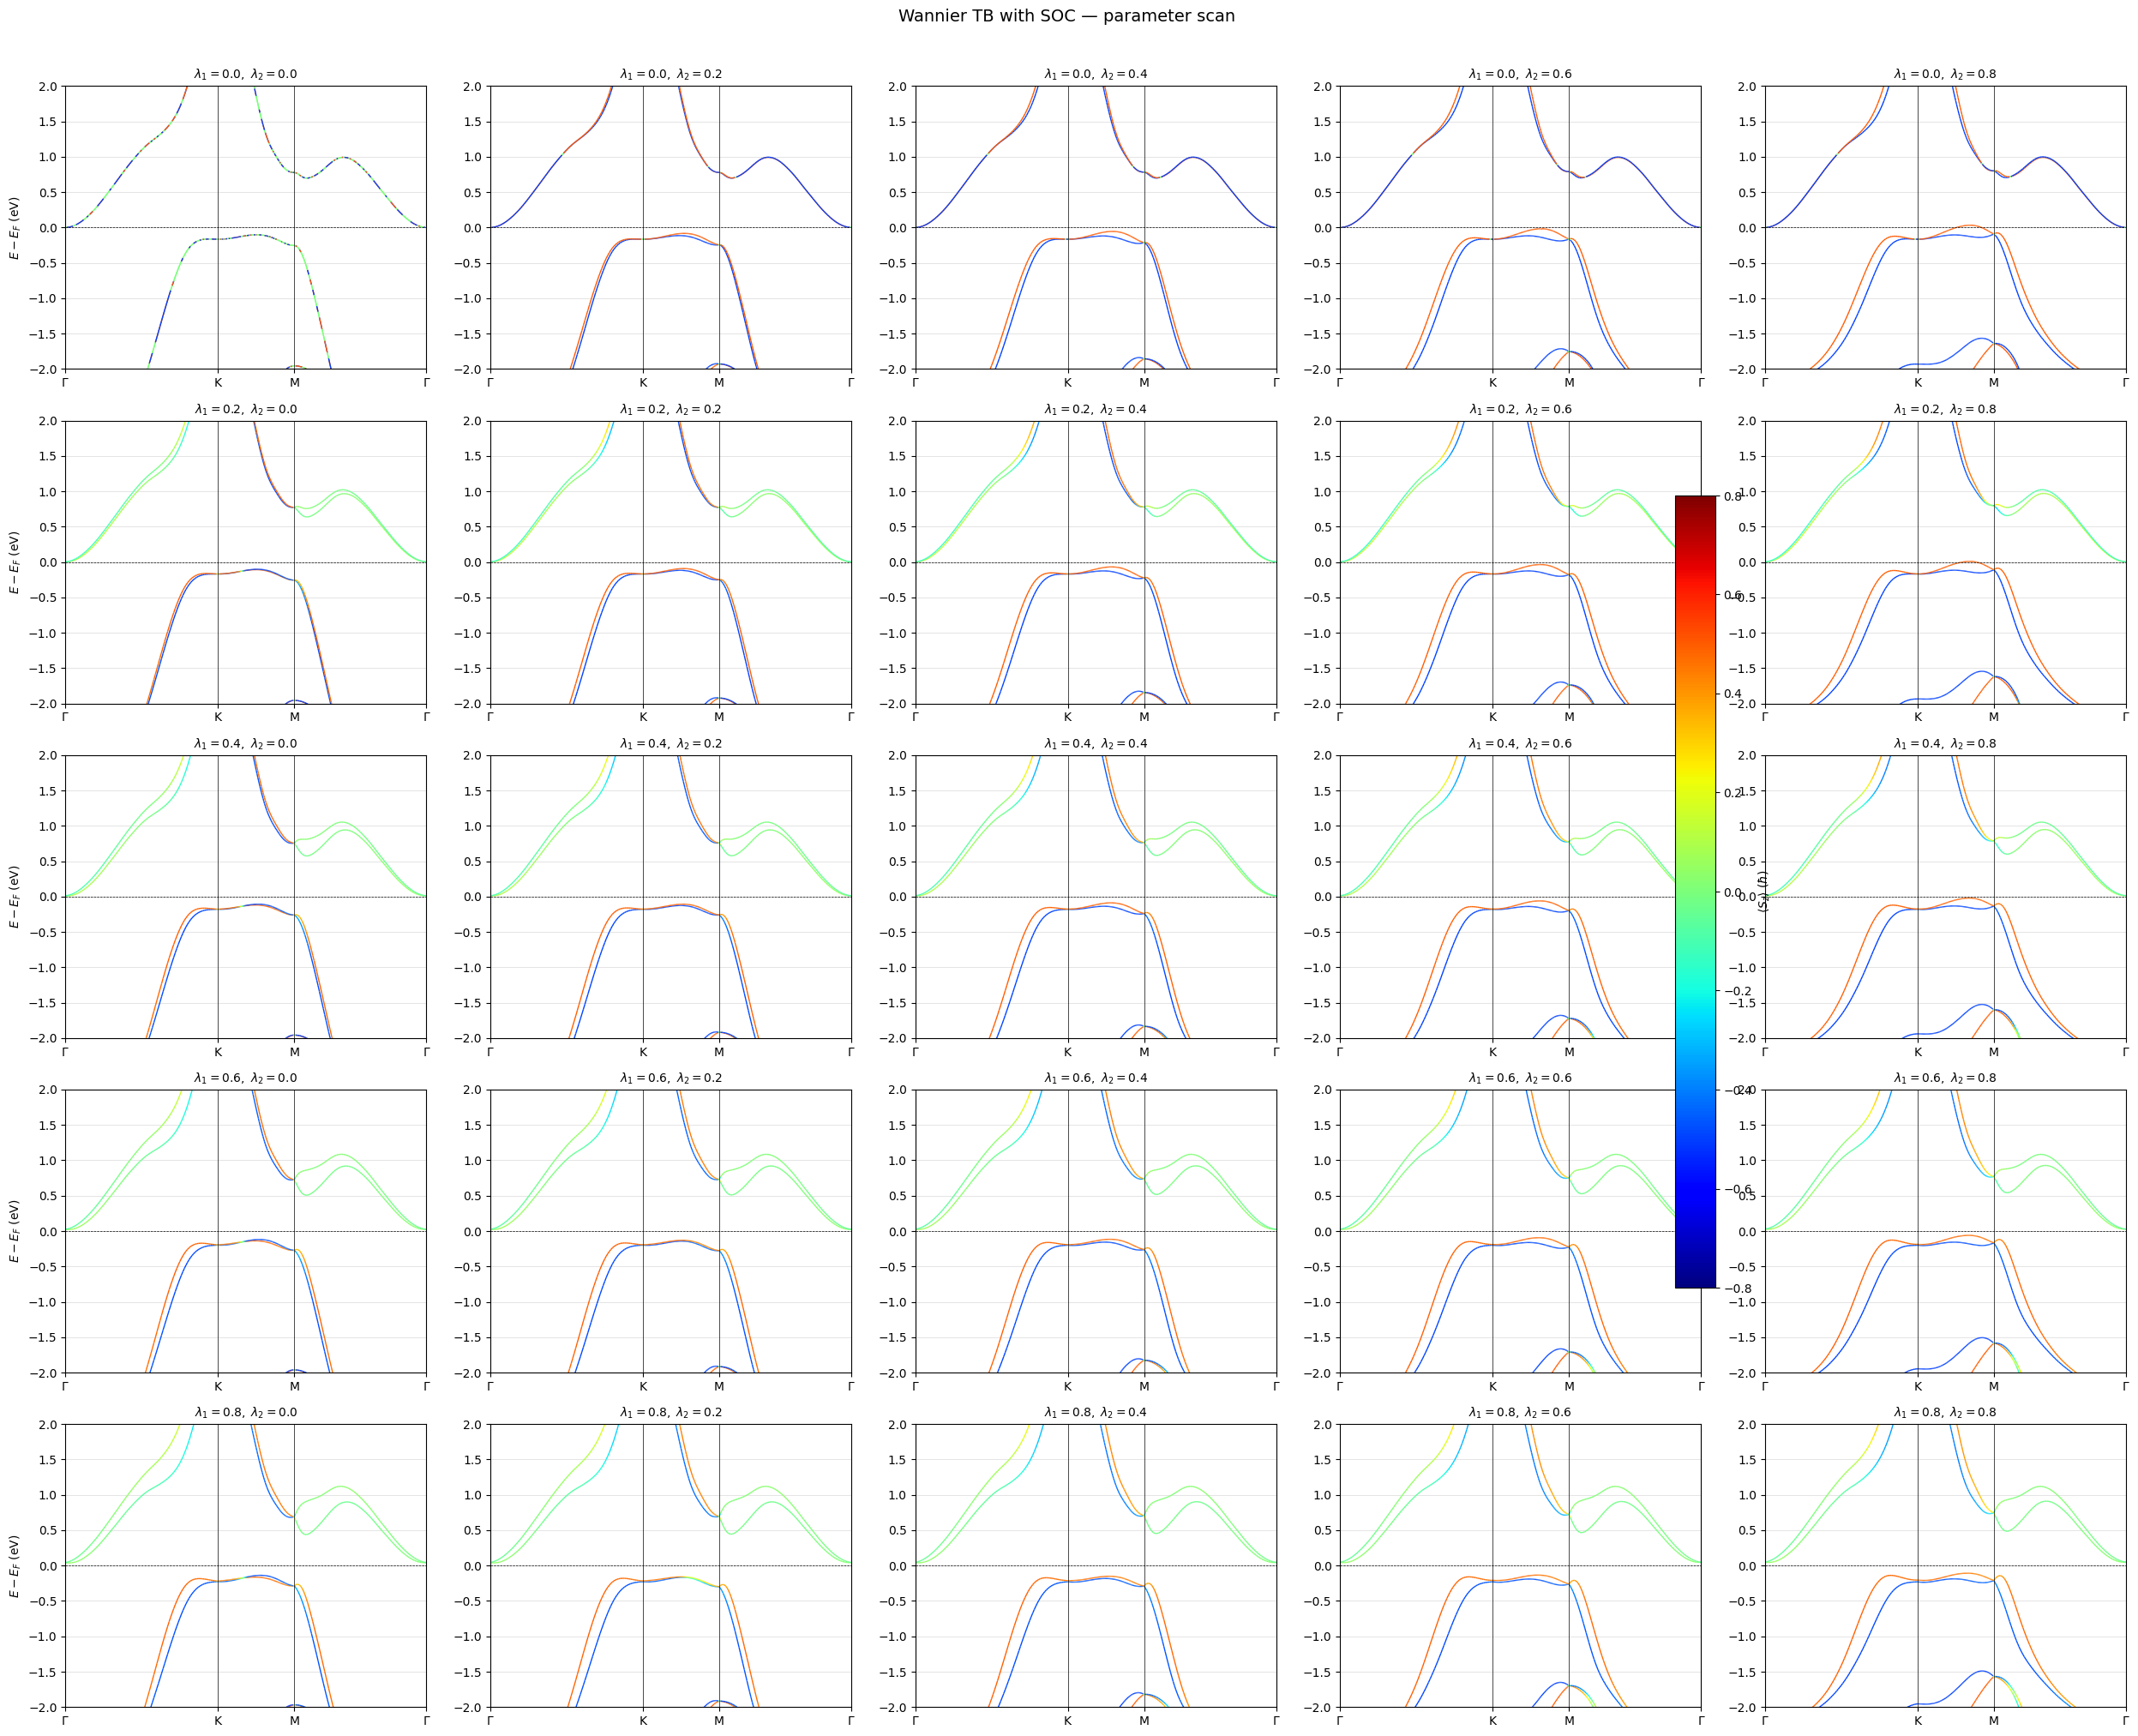

In [36]:
# Compute band structure with SOC along Gamma-K-M-Gamma
# Scan over multiple lambda1 and lambda2 values

lamb1_range = np.arange(0.0, 1.0, 0.2)  # [0.1, 0.3, 0.5, 0.7, 0.9]
lamb2_range = np.arange(0.0, 1.0, 0.2)  # [0.1, 0.2, 0.3, 0.4]

# Precompute no-SOC bands (only needed once)
Nk = len(kpts)
bands_noSOC = np.zeros((Nk, 16))
for ik, k in enumerate(kpts):
    evals, _, _ = solve_ham_SOC(k, 0, 0, EFermi)
    bands_noSOC[ik] = evals

# Color scheme matching dft_spin.png
from matplotlib.colors import Normalize
norm = Normalize(vmin=-0.8, vmax=0.8)
cmap = plt.cm.jet

n1, n2 = len(lamb1_range), len(lamb2_range)
fig, axes = plt.subplots(n1, n2, figsize=(5 * n2, 4 * n1), squeeze=False)

for i1, l1 in enumerate(lamb1_range):
    for i2, l2 in enumerate(lamb2_range):
        # Compute bands and <Sz>
        bands_SOC = np.zeros((Nk, 16))
        Sz_SOC = np.zeros((Nk, 16))
        for ik, k in enumerate(kpts):
            evals, _, sz = solve_ham_SOC(k, l1, l2, EFermi)
            bands_SOC[ik] = evals
            Sz_SOC[ik] = sz

        ax = axes[i1, i2]
        for ib in range(16):
            points = np.column_stack([x_axis, bands_SOC[:, ib]])
            segments = np.array([points[:-1], points[1:]]).transpose(1, 0, 2)
            colors = 0.5 * (Sz_SOC[:-1, ib] + Sz_SOC[1:, ib])
            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=1.0)
            lc.set_array(colors)
            ax.add_collection(lc)

        for xt in xticks:
            ax.axvline(xt, color='black', linewidth=0.5)
        ax.axhline(0, color='k', linewidth=0.5, linestyle='--')
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)
        ax.set_xlim(x_axis[0], x_axis[-1])
        ax.set_ylim(-2, 2)
        ax.set_title(rf'$\lambda_1={l1:.1f},\ \lambda_2={l2:.1f}$', fontsize=10)
        ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
        ax.grid(axis='y', color='gray', linewidth=0.5, alpha=0.3)

        if i2 == 0:
            ax.set_ylabel(r'$E - E_F$ (eV)')
        if i1 == n1 - 1:
            pass  # x labels already set

# Add shared colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, shrink=0.6, pad=0.02)
cbar.set_label(r'$\langle S_z \rangle$ ($\hbar$)')

plt.suptitle('Wannier TB with SOC — parameter scan', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

DFT SOC: kpoints (60, 3), eigenval (60, 60, 2, 1)
DFT SOC Fermi energy: 2.6689 eV


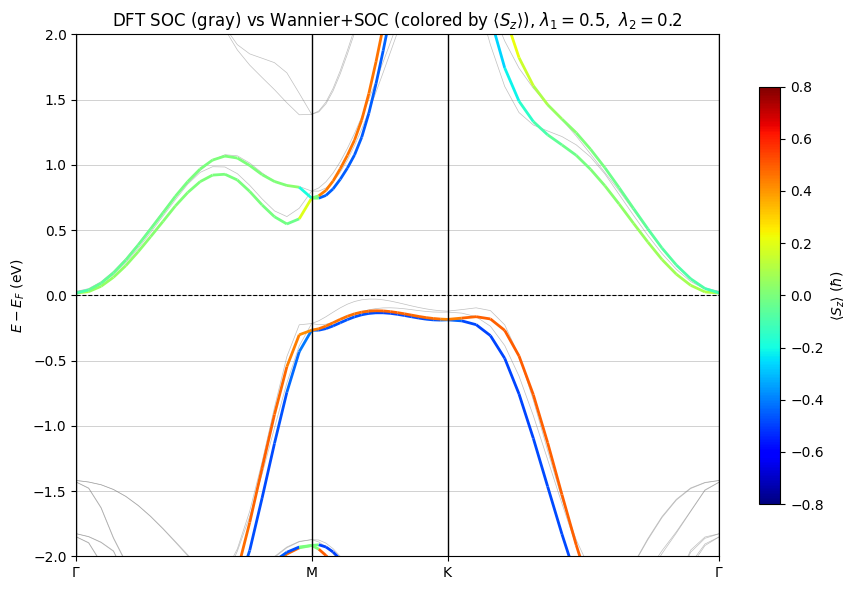

In [32]:
# Compare with DFT SOC bands
dft_SOC = np.load('bands_data-SOC.npz')
dft_kpoints_SOC = dft_SOC['kpoints']     # (60, 3)
dft_eigenval_SOC = dft_SOC['eigenval']   # (60, 60, 2, 1)
dft_efermi_SOC = float(dft_SOC['efermi'])

print(f"DFT SOC: kpoints {dft_kpoints_SOC.shape}, eigenval {dft_eigenval_SOC.shape}")
print(f"DFT SOC Fermi energy: {dft_efermi_SOC:.4f} eV")

# Convert DFT kpoints to fractional (same as Section 2)
k_frac_SOC = dft_kpoints_SOC @ np.linalg.inv(B_no2pi)

# Compute Wannier+SOC bands and <Sz> at DFT kpoints
Nk_dft = len(k_frac_SOC)
wannier_SOC_at_dft = np.zeros((Nk_dft, 16))
Sz_SOC_at_dft = np.zeros((Nk_dft, 16))
for ik, k in enumerate(k_frac_SOC):
    evals, _, sz = solve_ham_SOC(k, lamb1Val, lamb2Val, EFermi)
    wannier_SOC_at_dft[ik] = evals
    Sz_SOC_at_dft[ik] = sz

dft_bands_SOC = dft_eigenval_SOC[:, :, 0, 0] - dft_efermi_SOC  # (60, 60)

# Build DFT SOC x-axis (same kpath as no-SOC)
dft_x_SOC = np.zeros(len(dft_kpoints_SOC))
for i in range(1, len(dft_x_SOC)):
    dft_x_SOC[i] = dft_x_SOC[i-1] + np.linalg.norm(dft_kpoints_SOC[i] - dft_kpoints_SOC[i-1])
for iseg in range(1, 3):
    jump = dft_x_SOC[iseg*20] - dft_x_SOC[iseg*20 - 1]
    dft_x_SOC[iseg*20:] -= jump

dft_xticks_SOC = [dft_x_SOC[0], dft_x_SOC[19], dft_x_SOC[39], dft_x_SOC[59]]

# Plot comparison — same color scheme as dft_spin.png
from matplotlib.colors import Normalize
norm = Normalize(vmin=-0.8, vmax=0.8)
cmap = plt.cm.jet

fig, ax = plt.subplots(figsize=(9, 6))

# DFT SOC bands (gray background)
for ib in range(dft_bands_SOC.shape[1]):
    ax.plot(dft_x_SOC, dft_bands_SOC[:, ib], color='gray', linewidth=0.5, alpha=0.5)

# Wannier+SOC bands colored by <Sz>
for ib in range(16):
    points = np.column_stack([dft_x_SOC, wannier_SOC_at_dft[:, ib]])
    segments = np.array([points[:-1], points[1:]]).transpose(1, 0, 2)
    colors = 0.5 * (Sz_SOC_at_dft[:-1, ib] + Sz_SOC_at_dft[1:, ib])
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=2.0)
    lc.set_array(colors)
    ax.add_collection(lc)

for xt in dft_xticks_SOC:
    ax.axvline(xt, color='black', linewidth=1.0)
ax.axhline(0, color='k', linewidth=0.8, linestyle='--')

ax.set_xticks(dft_xticks_SOC)
ax.set_xticklabels([r'$\Gamma$', 'M', 'K', r'$\Gamma$'])
ax.set_ylabel(r'$E - E_F$ (eV)')
ax.set_title(rf'DFT SOC (gray) vs Wannier+SOC (colored by $\langle S_z\rangle$), $\lambda_1={lamb1Val},\ \lambda_2={lamb2Val}$')
ax.set_xlim(dft_x_SOC[0], dft_x_SOC[-1])
ax.set_ylim(-2, 2)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.grid(axis='y', color='gray', linewidth=0.5, alpha=0.5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label(r'$\langle S_z \rangle$ ($\hbar$)')

plt.tight_layout()
plt.show()